# Figure Generation for Manuscript

## Overview
This notebook outlines the generation of **Supplementary Figure S10** for the manuscript. Detailed steps, including data processing, benchmarking, visualization parameters, and export settings, are included to ensure reproducibility.

---

## **Supplementary Figure S10: Computational Efficiency Comparison**
### Description
Supplementary Figure S10 compares the computational performance of RISK and SAFE across scale-free networks of varying sizes. Metrics include CPU usage, memory consumption, and total runtime, demonstrating RISK’s scalability and efficiency for large and noisy datasets.

### Generation Steps
1. Generate synthetic scale-free networks of varying sizes (e.g., 10,000, 25,000, and 50,000 nodes).
2. Benchmark RISK and SAFE for clustering and annotation tasks on each network size.
3. Record CPU usage, memory consumption, and total runtime for both tools.
4. Visualize the benchmarking results using bar charts and line graphs.
5. Export the figure in SVG and PNG formats, ensuring compatibility with manuscript submission requirements.

---

## Workflow
- **Input Data**: Synthetic scale-free networks generated with predefined parameters.
- **Tools Used**: Python, RISK, SAFE, NetworkX, Matplotlib/Seaborn.
- **Output**: High-resolution figure for Supplementary Figure S10.

---

In [1]:
# First, plot computer hardware specs
# NOTE: make sure the specs are consistent between RISK and SAFE stress test analysis

In [2]:
%%bash

echo "System Information:"
echo "-------------------"
echo "CPU: $(lscpu | grep 'Model name' | awk -F: '{print $2}' | xargs)"
echo "Memory: $(free -h | awk '/^Mem:/{print $2}')"
echo "Disk Space: $(df -h --total | awk '/^total/{print $2}')"
echo "OS: $(lsb_release -d | awk -F: '{print $2}' | xargs)"
echo "Kernel: $(uname -r)"
echo "Architecture: $(uname -m)"

System Information:
-------------------
CPU: Intel(R) Xeon(R) Gold 5220 CPU @ 2.20GHz
Memory: 187G
Disk Space: 122T
OS: Ubuntu 18.04.6 LTS
Kernel: 5.4.0-132-generic
Architecture: x86_64


---

In [15]:
import os
import pickle
import random

import networkx as nx
import numpy as np


def generate_scale_free_network(num_nodes, m=2, random_seed=888):
    """
    Generate a Barabási-Albert scale-free network and assign systematic node IDs and attributes.

    Args:
        num_nodes (int): Number of nodes in the network.
        m (int): Number of edges to attach from a new node to existing nodes.
        random_seed (int): Seed for reproducibility.

    Returns:
        nx.Graph: A scale-free network with systematic node IDs and attributes, including 'x', 'y', and 'pos'.
    """
    # Set random seed for reproducibility
    random.seed(random_seed)
    np.random.seed(random_seed)
    # Generate a scale-free network
    graph = nx.barabasi_albert_graph(num_nodes, m=m, seed=random_seed)
    # Relabel nodes to 1 → N
    graph = nx.convert_node_labels_to_integers(graph, first_label=1)
    # Assign attributes to nodes
    for node in graph.nodes():
        # Assign 'x', 'y' coordinates and 'pos'
        x = np.random.uniform(0, 1)  # Random x-coordinate between 0 and 1
        y = np.random.uniform(0, 1)  # Random y-coordinate between 0 and 1
        graph.nodes[node]["x"] = x
        graph.nodes[node]["y"] = y
        graph.nodes[node]["pos"] = (x, y)  # Combine x and y into pos

    return graph


def export_to_gpickle(graph, file_path):
    """
    Export the given NetworkX graph to a GPickle file.

    Args:
        graph (nx.Graph): The NetworkX graph to export.
        file_path (str): The path to save the gpickle file.
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    try:
        with open(file_path, "wb") as file:
            pickle.dump(graph, file, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Graph successfully exported to {file_path}")
    except Exception as e:
        print(f"An error occurred while exporting the graph: {e}")


def generate_and_export_scale_free_networks(output_dir, edge_counts, m=2):
    """
    Generate scale-free networks for a range of sizes and export them to GPickle format.

    Args:
        output_dir (str): Directory to save the GPickle files.
        edge_counts (list): List of edge counts to create networks for.
        m (int): Number of edges to attach from a new node to existing nodes.
    """
    for edge_count in edge_counts:
        # Approximate the number of nodes based on edge count (average degree = 2m for scale-free networks)
        num_nodes = edge_count // m
        graph = generate_scale_free_network(num_nodes, m=m)
        file_name = f"scale_free_network_with_{num_nodes}_nodes_and_{edge_count}_edges.gpickle"
        export_to_gpickle(graph, os.path.join(output_dir, file_name))


# Configuration
output_directory = "./data/gpickle/benchmark"
edge_counts = [
    100,        # Small network
    1_000,      # Medium-small network
    10_000,     # Medium network
    50_000,     # Transition point for finer intervals
    100_000,    # Large network
    150_000,    # Precision begins: finer step
    200_000,    # Continue finer intervals
    250_000,    # Mid-range precision
    300_000,    # Fine step scaling continues
    350_000,    # Midpoint between 250k and 500k
    400_000,    # Smoother scaling toward cap
    450_000,    # Nearing the upper cap
    500_000,    # Upper limit
    550_000,  # Extending to 750k
    600_000,  # Fine scaling
    650_000,  # Precision toward the next tier
    700_000,  # Almost at cap
    750_000,  # Final upper limit
]

# Generate and export networks
# generate_and_export_scale_free_networks(output_directory, edge_counts)

In [4]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd


def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


def read_gpickle(filepath):
    with open(filepath, "rb") as f:
        G = pickle.load(f)
    return G


def write_json(data, file_path):
    try:
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)
        print(f"Dictionary successfully written to {file_path}")
    except Exception as e:
        print(f"An error occurred while writing to JSON: {e}")

In [5]:
# Read true GO BP annotation to mimic mock annotation

go_bp = read_json("./data/json/annotations/go_biological_process.json")
len(go_bp)

2214

In [6]:
import random
import numpy as np


def mock_annotations(go_bp, num_terms=5000, random_seed=42):
    """
    Create a mock annotation dictionary based on the distribution of gene set sizes in `go_bp`,
    assigning unique integer IDs to genes.

    Args:
        go_bp (dict): Original annotations mapping terms to lists of genes.
        num_terms (int): Number of mock annotation terms to generate. Defaults to 5000.
        random_seed (int): Seed for reproducibility. Defaults to 42.

    Returns:
        dict: Mock annotation dictionary with erroneous terms mapping to random integer node IDs.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Extract unique genes from go_bp and assign unique integer IDs
    unique_genes = sorted(set(gene for genes in go_bp.values() for gene in genes))
    gene_to_id = {gene: idx + 1 for idx, gene in enumerate(unique_genes)}

    # Create a pool of IDs corresponding to unique genes
    id_pool = list(gene_to_id.values())

    # Extract the distribution of gene set sizes from go_bp
    set_sizes = [len(genes) for genes in go_bp.values()]

    # Generate mock annotations
    mock_annotations = {}
    for i in range(num_terms):
        term_name = f"erroneous_term_{i + 1}"
        set_size = random.choice(set_sizes)  # Sample a size based on the distribution
        mock_annotations[term_name] = [
            str(i) for i in random.sample(id_pool, min(set_size, len(id_pool)))
        ]

    return mock_annotations


# Create mock annotations
mock_go_bp = mock_annotations(go_bp, num_terms=1000, random_seed=888)

# Export to JSON for reuse
# write_json(mock_go_bp, './data/json/benchmark/20250125_1000_mock_go_bp_annotations.json')

# Check a sample of the result
print(list(mock_go_bp.items())[:5])
print()
print(f"Total mock terms generated: {len(mock_go_bp)}")

[('erroneous_term_1', ['3539', '3647', '4069', '3162', '3070', '4436', '3427', '1409', '3221', '3092', '3542', '2240', '3084', '4423', '88', '4334', '3049', '3256', '1980', '2569', '2156', '1854', '913', '2491', '2336', '1352', '3756', '1935', '1635', '1874', '342', '1712', '4242', '3974', '112', '633', '3653', '3578']), ('erroneous_term_2', ['4213', '2580', '2236', '2283', '4220', '1233', '307', '1812', '2912', '3229', '3151', '4050', '1723', '1790', '4352', '2509', '2302', '1044', '513', '2752', '909', '4394', '4083']), ('erroneous_term_3', ['338', '111', '1995', '3746', '4247', '608', '407', '834', '448', '2519', '1140', '1365', '3138']), ('erroneous_term_4', ['1105', '2318', '2670', '2028', '282', '2774', '919', '2552', '556', '948']), ('erroneous_term_5', ['736', '1153', '283', '768', '436', '799', '3961', '1365', '2223', '3939', '2727', '2000', '3890', '680', '1489', '348', '1419', '3545', '1239', '2883', '1701', '2499', '171', '2439', '2143', '2526', '2983', '2038', '983', '2329

## Load RISK and set up pipeline for benchmarking

This code block merely sets up the environment for running RISK in a benchmarking pipeline.

In [7]:
import risk

print(risk.__version__)

0.0.9


In [9]:
# Initialize the RISK object

from risk import RISK

risk = RISK(verbose=False)

In [16]:
#  Sphere with 0 depth is the best for the citation network
network = risk.load_gpickle_network(
    "./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges.gpickle",
    compute_sphere=False,
    surface_depth=0.0,
    min_edges_per_node=0,
)

# Load annotations
annotations = risk.load_dict_annotation(
    network=network,
    content=mock_go_bp,
)

500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


In [17]:
# Perform annotation overrepresentation analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods = risk.load_neighborhoods_by_permutation(
    network=network,
    annotations=annotations,
    distance_metric="louvain",
    louvain_resolution=2,
    fraction_shortest_edges=0.5,
    score_metric="sum",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=4,
)

Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.86it/s]


In [20]:
# Get the NetworkGraph object for plotting

graph = risk.load_graph(
    network=network,
    annotations=annotations,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=1.0,
    fdr_cutoff=1.0,
    impute_depth=0,
    prune_threshold=0.0,
    linkage_criterion="distance",
    linkage_method="average",
    linkage_metric="cosine",
    linkage_threshold=0.2,
    min_cluster_size=10,
    max_cluster_size=100_000,
)

Evaluating optimal linkage method and metric: 100%|███████████████████████████████████| 1/1 [00:00<00:00]


Linkage criterion: 'distance'
Linkage method: 'average'
Linkage metric: 'cosine'
Linkage threshold: 0.2
Error encountered. Skipping clustering and assigning 345 unique domains.


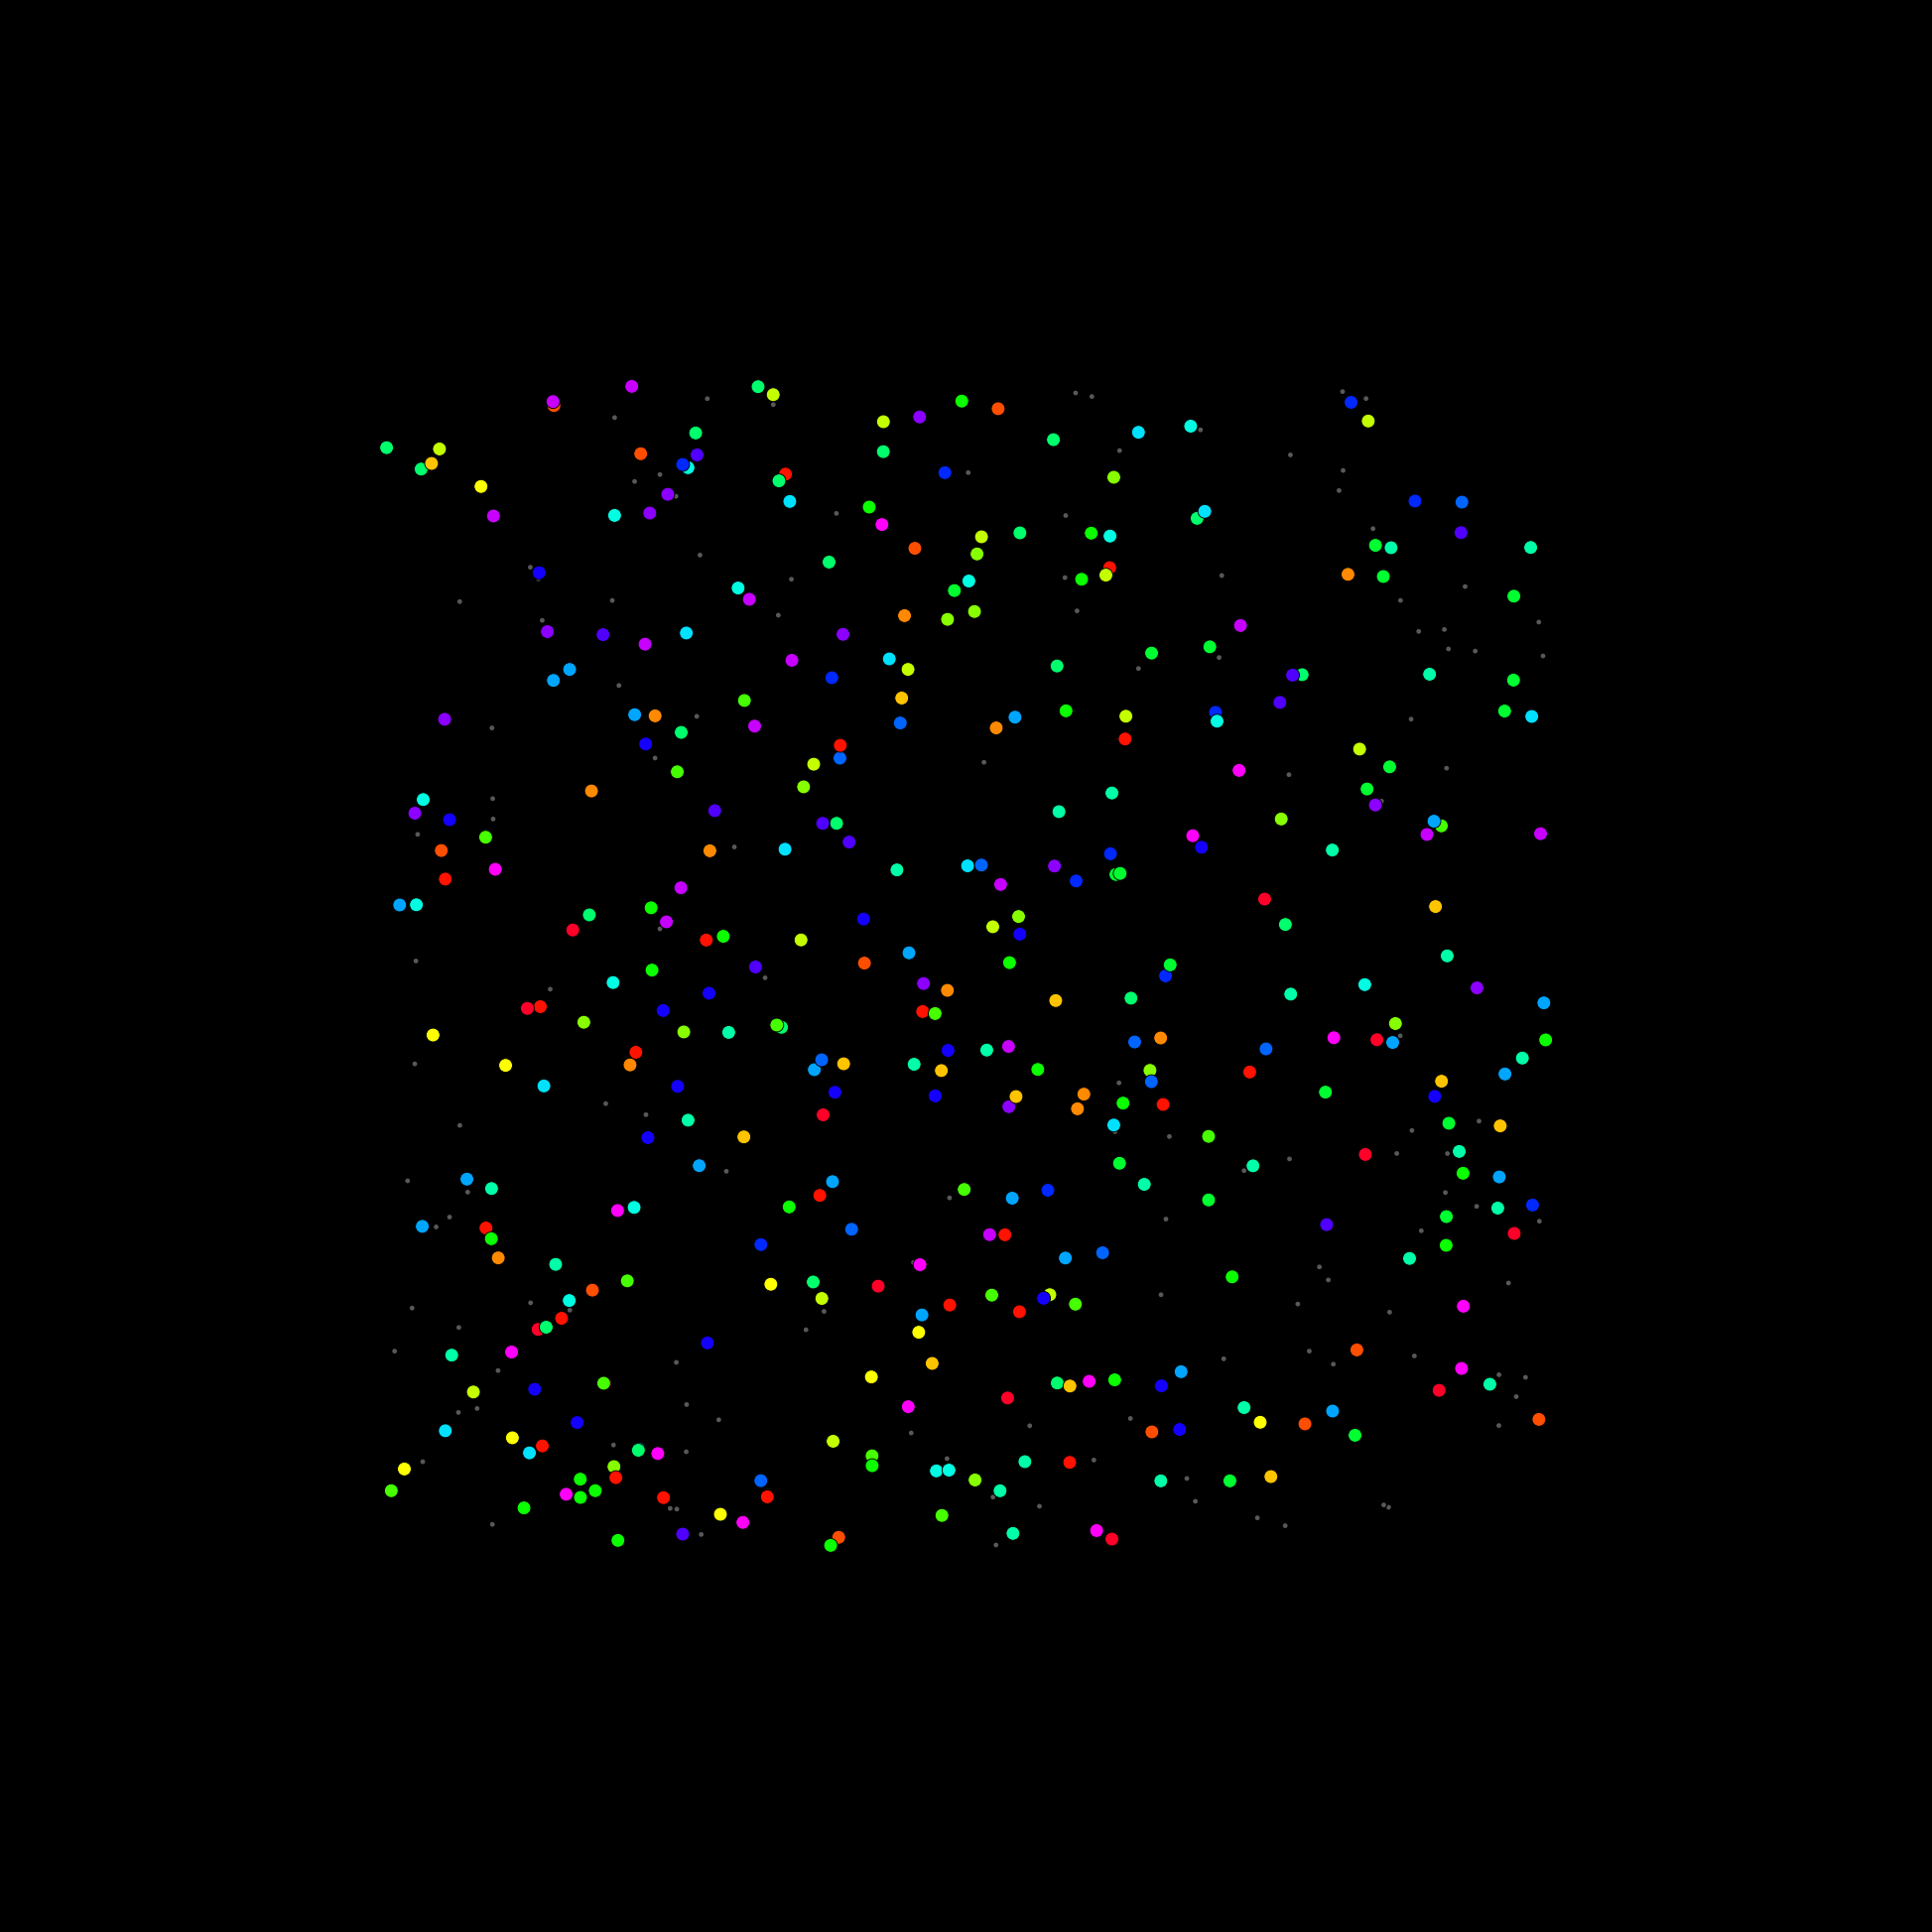

In [22]:
# Plot citations network with subfield annotations

r = 903

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(20, 20),
    background_color="black",
)

# Plot a subnetwork with custom node and edge attributes
plotter.plot_subnetwork(
    nodes=graph.node_id_to_node_label_map.values(),
    node_size=20,
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.00,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=0.35,
    edge_alpha=1.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=100,
        nonsignificant_size=0,
    ),
    node_edgewidth=0.65,
    node_shape="o",
    edge_width=0.0,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        # color="black",
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.25,
        alpha=0.75,
        blend_colors=False,
        nonsignificant_color="white",
        nonsignificant_alpha=0.5,
        random_seed=r,
    ),
    # node_color="grey",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Display the plot
plotter.show()

## RISK computational performance pipeline

- Use the following specs:
    - Louvain clustering
    - 1,000 annotations with gene count distribution similar to GO BP
    - 4 processors (multiprocessing)
    - 1,000 permutations
    - Avg of 5 runs per dataset

In [23]:
import time
import tracemalloc
import psutil  # For CPU time tracking
from risk import RISK


def measure_performance(func, *args, **kwargs):
    """
    Measure the execution time, CPU time, and memory usage of a function.

    Args:
        func (callable): The function to measure.
        *args: Positional arguments for the function.
        **kwargs: Keyword arguments for the function.

    Returns:
        tuple: (result of the function, performance metrics dict)
    """
    tracemalloc.start()
    start_time = time.time()
    process = psutil.Process()  # Track the process for CPU times
    cpu_times_before = process.cpu_times()

    result = func(*args, **kwargs)

    end_time = time.time()
    cpu_times_after = process.cpu_times()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    metrics = {
        "execution_time": end_time - start_time,
        "cpu_user_time": cpu_times_after.user - cpu_times_before.user,
        "cpu_system_time": cpu_times_after.system - cpu_times_before.system,
        "current_memory_usage": current_memory / 1024 / 1024,  # Convert to MB
        "peak_memory_usage": peak_memory / 1024 / 1024,  # Convert to MB
    }
    return result, metrics


def benchmark_risk_workflow(
    file_path, annotations_content, num_permutations=1000, max_workers=6, num_runs=5
):
    """
    Benchmark the RISK workflow as a single block combining all operations.

    Args:
        file_path (str): Path to the network file (.gpickle).
        annotations_content (dict): Annotations content for the network.
        num_permutations (int): Number of permutations for the neighborhood computation. Defaults to 1000.
        max_workers (int): Number of workers for parallel computation. Defaults to 6.
        num_runs (int): Number of runs for averaging. Defaults to 5.

    Returns:
        dict: Benchmark metrics with averages and standard deviations.
    """
    combined_metrics = []

    for _ in range(num_runs):
        # Combined Block: Load network, annotations, and perform permutation test
        def execute_workflow():
            network = risk.load_gpickle_network(
                file_path,
                compute_sphere=False,
                surface_depth=0.0,
                min_edges_per_node=0,
            )
            annotations = risk.load_dict_annotation(
                network=network,
                content=annotations_content,
            )
            return risk.load_neighborhoods_by_permutation(
                network=network,
                annotations=annotations,
                distance_metric="louvain",
                louvain_resolution=2,
                fraction_shortest_edges=0.20,
                score_metric="sum",
                null_distribution="network",
                num_permutations=num_permutations,
                random_seed=887,
                max_workers=max_workers,
            )

        _, workflow_metrics = measure_performance(execute_workflow)
        combined_metrics.append(workflow_metrics)

    # Helper function to calculate averages and standard deviations
    def calculate_stats(metrics_list):
        import statistics

        return {
            "avg_execution_time": statistics.mean([m["execution_time"] for m in metrics_list]),
            "stdev_execution_time": (
                statistics.stdev([m["execution_time"] for m in metrics_list]) if num_runs > 1 else 0
            ),
            "avg_cpu_user_time": statistics.mean([m["cpu_user_time"] for m in metrics_list]),
            "stdev_cpu_user_time": (
                statistics.stdev([m["cpu_user_time"] for m in metrics_list]) if num_runs > 1 else 0
            ),
            "avg_cpu_system_time": statistics.mean([m["cpu_system_time"] for m in metrics_list]),
            "stdev_cpu_system_time": (
                statistics.stdev([m["cpu_system_time"] for m in metrics_list])
                if num_runs > 1
                else 0
            ),
            "avg_current_memory_usage": statistics.mean(
                [m["current_memory_usage"] for m in metrics_list]
            ),
            "stdev_current_memory_usage": (
                statistics.stdev([m["current_memory_usage"] for m in metrics_list])
                if num_runs > 1
                else 0
            ),
            "avg_peak_memory_usage": statistics.mean(
                [m["peak_memory_usage"] for m in metrics_list]
            ),
            "stdev_peak_memory_usage": (
                statistics.stdev([m["peak_memory_usage"] for m in metrics_list])
                if num_runs > 1
                else 0
            ),
        }

    return calculate_stats(combined_metrics)

In [24]:
# Example Configuration
file_path = "./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges.gpickle"

# Benchmark the workflow
metrics_500 = benchmark_risk_workflow(
    file_path=file_path,
    annotations_content=mock_go_bp,
    num_permutations=1000,
    max_workers=4,
    num_runs=5,
)

# Print results
print("Performance results:", metrics_500)

500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.71it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.76it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.72it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.26it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.02it/s]

Performance results: {'avg_execution_time': 4.423979806900024, 'stdev_execution_time': 0.21604238122483763, 'avg_cpu_user_time': 0.9079999999999956, 'stdev_cpu_user_time': 0.1931838502566895, 'avg_cpu_system_time': 0.12200000000000007, 'stdev_cpu_system_time': 0.0192353840616714, 'avg_current_memory_usage': 4.308572769165039, 'stdev_current_memory_usage': 0.06326409721890762, 'avg_peak_memory_usage': 22.193815612792967, 'stdev_peak_memory_usage': 0.06364260094256761}


## Loop through mock Gpickle datasets and generate performance results

In [ ]:
import os
import gc
import psutil
import sys


def loop_and_benchmark_gpickle_files(
    gpickle_directory,
    json_output_directory,
    annotations_content,
    num_permutations=1_000,
    max_workers=6,
    num_runs=5,
    mem_threshold=80,  # Percentage of total memory usage to trigger safe exit
):
    """
    Loop through all `.gpickle` files in a directory, benchmark them, and save the results to JSON files.

    Args:
        gpickle_directory (str): Directory containing the `.gpickle` files.
        json_output_directory (str): Directory to save the JSON benchmark results.
        annotations_content (dict): Annotations content for benchmarking.
        num_permutations (int): Number of permutations for the neighborhood computation. Defaults to 1000.
        max_workers (int): Number of workers for parallel computation. Defaults to 6.
        num_runs (int): Number of runs for averaging. Defaults to 5.
        mem_threshold (int): Memory usage percentage threshold to trigger a safe exit. Defaults to 80%.
    """
    os.makedirs(json_output_directory, exist_ok=True)

    # Get all `.gpickle` files in the directory, sorted by node count (ascending)
    sorted_files = sorted(
        [
            (file_name, int(file_name.split("_")[4]))  # Extract node count from filename
            for file_name in os.listdir(gpickle_directory)
            if file_name.endswith(".gpickle")
        ],
        key=lambda x: x[1],  # Sort by extracted node count
    )

    # Loop through the sorted files
    for file_name, ctime in sorted_files:
        # Check memory usage before processing the file
        memory_usage = psutil.virtual_memory().percent
        if memory_usage > mem_threshold:
            print(
                f"Memory usage {memory_usage}% exceeds threshold ({mem_threshold}%). Exiting safely."
            )
            sys.exit(1)  # Exit safely if memory threshold is exceeded

        file_path = os.path.join(gpickle_directory, file_name)
        base_name = os.path.splitext(file_name)[0]
        json_path = os.path.join(json_output_directory, f"{base_name}_benchmark.json")

        print(f"Processing {file_name}, created at {ctime}")
        print(f"Benchmarking {file_path}...")

        try:
            # Perform benchmarking
            metrics = benchmark_risk_workflow(
                file_path=file_path,
                annotations_content=annotations_content,
                num_permutations=num_permutations,
                max_workers=max_workers,
                num_runs=num_runs,
            )

            # Save the results to JSON
            write_json(metrics, json_path)
            print(f"Saved results to {json_path}")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

        # Clear memory to prevent interference
        del metrics
        gc.collect()


# Clear all unused objects prior to test
gc.collect()

# Example usage
gpickle_directory = "./data/gpickle/benchmark"
json_output_directory = "./data/json/benchmark/risk"


# NOTE: The workflow below has been moved to a standalone script ('supp_fig_5.py').
# On Linux systems, use ulimit to cap the maximum allowed memory for the script.
# For example, the command below will run 'supp_fig_5.py' with a 15GB memory limit:
# $ ulimit -v $((15 * 1024 * 1024)) && python supp_fig_5.py

# # Benchmark all `.gpickle` files and save results to JSON
# loop_and_benchmark_gpickle_files(
#     gpickle_directory=gpickle_directory,
#     json_output_directory=json_output_directory,
#     annotations_content=mock_go_bp,
#     num_permutations=1_000,
#     max_workers=3,
#     num_runs=5,
#     mem_threshold=95,  # Set memory threshold to 95%
# )

Processing scale_free_network_with_50_nodes_and_100_edges.gpickle, created at 50
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges.gpickle...
50 out of 50 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 628.59it/s]

50 out of 50 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.



Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 625.11it/s]


50 out of 50 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 624.25it/s]

50 out of 50 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.



Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 623.75it/s]


50 out of 50 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 612.64it/s]


Dictionary successfully written to ./data/json/benchmark/risk/scale_free_network_with_50_nodes_and_100_edges_benchmark.json
Saved results to ./data/json/benchmark/risk/scale_free_network_with_50_nodes_and_100_edges_benchmark.json
Processing scale_free_network_with_500_nodes_and_1000_edges.gpickle, created at 500
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges.gpickle...
500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.68it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.27it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:02<00:00, 465.09it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:02<00:00, 460.05it/s]


500 out of 500 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.91it/s]


Dictionary successfully written to ./data/json/benchmark/risk/scale_free_network_with_500_nodes_and_1000_edges_benchmark.json
Saved results to ./data/json/benchmark/risk/scale_free_network_with_500_nodes_and_1000_edges_benchmark.json
Processing scale_free_network_with_5000_nodes_and_10000_edges.gpickle, created at 5000
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges.gpickle...
5000 out of 5000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.89it/s]


5000 out of 5000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.75it/s]


5000 out of 5000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.96it/s]


5000 out of 5000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.93it/s]


5000 out of 5000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.81it/s]


Dictionary successfully written to ./data/json/benchmark/risk/scale_free_network_with_5000_nodes_and_10000_edges_benchmark.json
Saved results to ./data/json/benchmark/risk/scale_free_network_with_5000_nodes_and_10000_edges_benchmark.json
Processing scale_free_network_with_50000_nodes_and_100000_edges.gpickle, created at 50000
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_50000_nodes_and_100000_edges.gpickle...
50000 out of 50000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.42it/s]


50000 out of 50000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [03:13<00:00,  5.18it/s]


50000 out of 50000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [03:06<00:00,  5.35it/s]


50000 out of 50000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [03:10<00:00,  5.26it/s]


50000 out of 50000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [03:11<00:00,  5.23it/s]


Dictionary successfully written to ./data/json/benchmark/risk/scale_free_network_with_50000_nodes_and_100000_edges_benchmark.json
Saved results to ./data/json/benchmark/risk/scale_free_network_with_50000_nodes_and_100000_edges_benchmark.json
Processing scale_free_network_with_125000_nodes_and_250000_edges.gpickle, created at 125000
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_125000_nodes_and_250000_edges.gpickle...
125000 out of 125000 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [08:20<00:00,  4.68it/s]IOStream.flush timed out
Total progress: 1020it [09:57,  2.56s/it]                                                                

## Supplementary Figure S10 will be generated here

#### Visit `safe-examples/supp_fig_5.ipynb` to generate benchmark data for comparative analysis

Make sure to copy over the JSON results over to a local data directory when finished

- RISK results are stored in: ./data/json/benchmark/risk
- SAFE results are stored in: ./data/json/benchmark/safe

## Make Supplementary Figure S10

Load dataset generated from previous codeblock and do a comparison with SAFE on computational performance

In [3]:
import json
import matplotlib.pyplot as plt


def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


# Set the background to black for all plots
plt.rcParams["figure.facecolor"] = "black"  # Set the figure background color
plt.rcParams["axes.facecolor"] = "black"  # Set the axes background color
plt.rcParams["savefig.facecolor"] = "black"  # Set the background for saved figures
plt.rcParams["axes.edgecolor"] = "white"  # Optional: Make the axis edge white for visibility
plt.rcParams["axes.labelcolor"] = "white"  # Optional: Make axis labels white
plt.rcParams["xtick.color"] = "white"  # Optional: Make x-ticks white
plt.rcParams["ytick.color"] = "white"  # Optional: Make y-ticks white
plt.rcParams["text.color"] = "white"  # Optional: Set text color to white

In [7]:
# Read and process benchmark JSON files


def read_benchmark_data(directory):
    data = []
    for file_name in os.listdir(directory):
        if file_name.startswith("scale_free_network") and file_name.endswith(".json"):
            # Extract edge count from file name
            edge_count = int(file_name.split("_and_")[1].split("_edges")[0])
            file_path = os.path.join(directory, file_name)
            with open(file_path, "r") as f:
                content = json.load(f)
                content["edge_count"] = edge_count
                data.append(content)
    return sorted(data, key=lambda x: x["edge_count"])  # Order by edge count


# Create a union of edge counts from all datasets
def get_all_edges(data_list):
    all_edges = set()
    for data in data_list:
        all_edges.update([d["edge_count"] for d in data])
    return sorted(all_edges)


# Align data by all edge counts
def align_data(data, all_edges):
    aligned = {key: [] for key in data[0] if key != "edge_count"}
    aligned["edge_count"] = all_edges
    for edge in all_edges:
        entry = next((d for d in data if d["edge_count"] == edge), None)
        for key in aligned.keys():
            if key != "edge_count":
                aligned[key].append(entry[key] if entry else np.nan)
    return aligned


# Filter data to ensure no invalid values
def filter_data(data, keys):
    for key in keys:
        data[key] = [val if val > 0 else np.nan for val in data[key]]

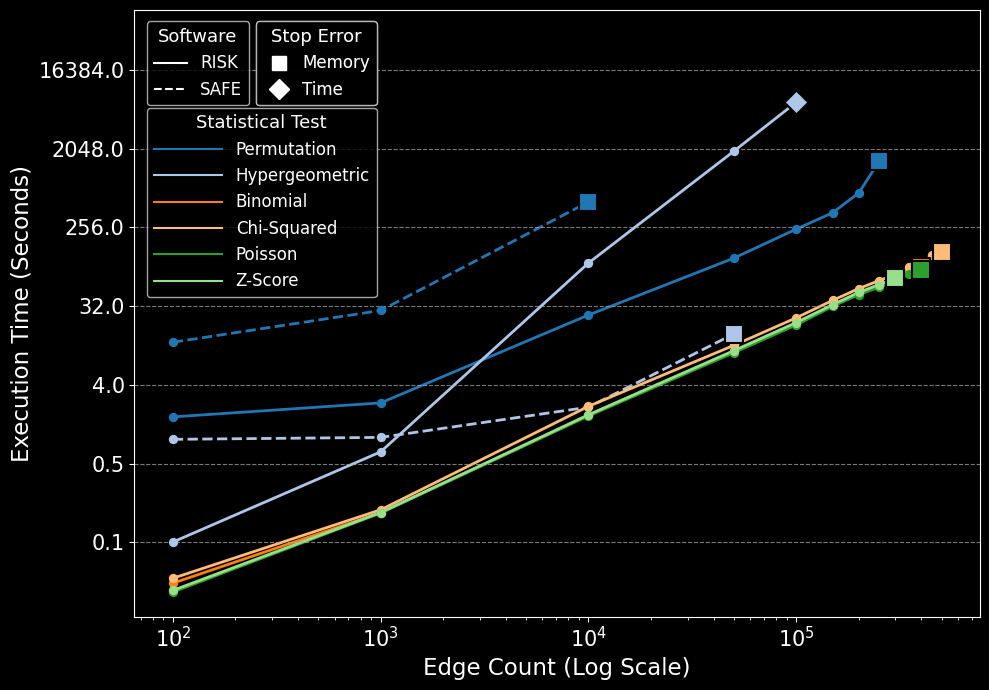

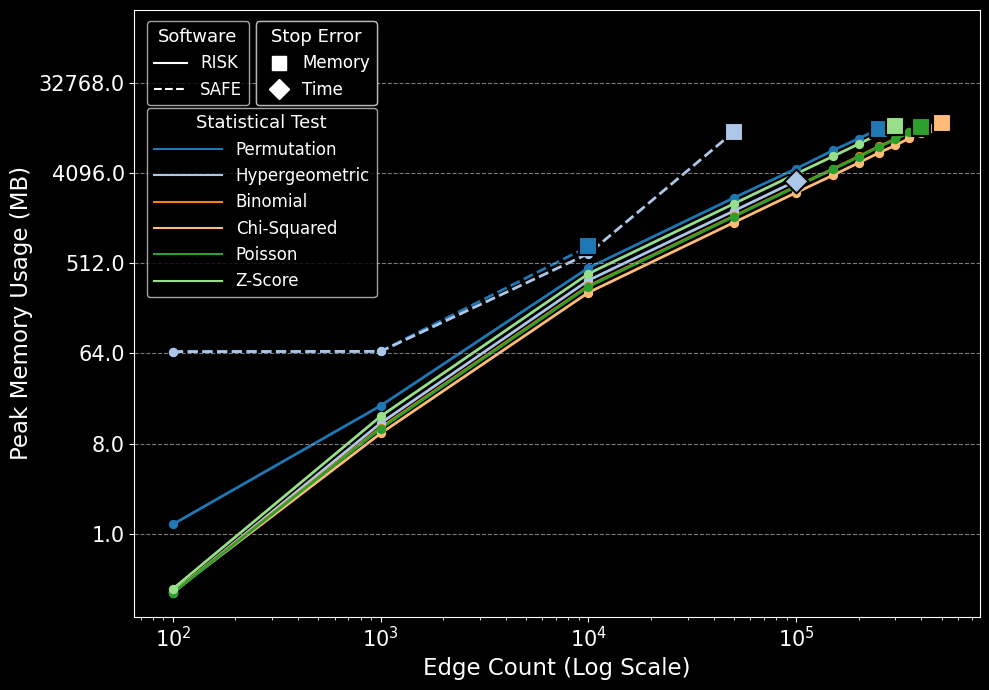

In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# Legend to directory mapping
fig_legend_to_stat_dir = {
    "RISK: Permutation": "./data/json/benchmark/risk/20250125_1000_permutations_3_workers",
    "SAFE: Permutation": "./data/json/benchmark/safe/20250125_1000_permutations_3_workers",
    "RISK: Hypergeometric": "./data/json/benchmark/risk/20250125_hypergeom",
    "SAFE: Hypergeometric": "./data/json/benchmark/safe/20250125_hypergeom",
    "RISK: Binomial": "./data/json/benchmark/risk/20250125_binom",
    "RISK: Chi-Squared": "./data/json/benchmark/risk/20250125_chi2",
    "RISK: Poisson": "./data/json/benchmark/risk/20250125_poisson",
    "RISK: Z-Score": "./data/json/benchmark/risk/20250125_zscore",
}

# Get the tab20 colormap
tab20 = plt.get_cmap("tab20")
# Define test-specific styles with distinct colors
test_styles = {
    "Permutation": {"color": tab20(0)},
    "Hypergeometric": {"color": tab20(1)},
    "Binomial": {"color": tab20(2)},
    "Chi-Squared": {"color": tab20(3)},
    "Poisson": {"color": tab20(4)},
    "Z-Score": {"color": tab20(5)},
}

# Final scatter point styles
# Square --> Stop Error due to memory issues
# Diamond --> Stop Error due to time issues
final_point_styles = {
    "RISK: Permutation": "s",
    "SAFE: Permutation": "s",
    "RISK: Hypergeometric": "D",
    "SAFE: Hypergeometric": "s",
    "RISK: Binomial": "s",
    "RISK: Chi-Squared": "s",
    "RISK: Poisson": "s",
    "RISK: Z-Score": "s",
}


# Read and process files
# Add stacked legends with precise coordinates
def plot_metric_comparison(
    fig_legend_to_stat_dir, test_styles, metric, error_metric, xlabel, ylabel, title, filename
):
    plt.figure(figsize=(10, 7))

    # Create handles for the legends
    style_handles = []  # For RISK and SAFE
    test_handles = []  # For statistical tests
    max_y = 0

    for legend, directory in fig_legend_to_stat_dir.items():
        data = read_benchmark_data(directory)
        stat_test = legend.split(":")[1].strip()  # Extract statistical test name
        all_edges = get_all_edges([data])
        aligned_data = align_data(data, all_edges)

        # Filter data to avoid invalid values
        filter_data(aligned_data, [metric, error_metric])

        # Determine style based on RISK or SAFE
        is_risk = "RISK" in legend
        linestyle = "-" if is_risk else "--"
        color = test_styles[stat_test]["color"]

        # Plot the line
        plt.plot(
            aligned_data["edge_count"],
            aligned_data[metric],
            linestyle=linestyle,
            label=legend,  # Label is only used for dual legend handles
            color=color,
            zorder=1,  # Ensures the line is below scatter points
            alpha=1,
            linewidth=2.0,
        )

        # Plot all scatter points except the last
        plt.scatter(
            aligned_data["edge_count"][:-1],
            aligned_data[metric][:-1],
            label=None,  # Prevents duplicate labels in the legend
            color=color,
            s=32.5,
            zorder=2,  # Ensures scatter points are above the line
        )

        # Plot the final scatter point with a distinct style
        last_x = aligned_data["edge_count"][-1]
        last_y = aligned_data[metric][-1]
        # Set largest y pos
        max_y = last_y if last_y > max_y else max_y
        plt.scatter(
            last_x,
            last_y,
            label=None,
            color=color,
            marker=final_point_styles[legend],  # Use the shape from the mapping
            edgecolor="black",  # Highlight the final point
            linewidths=1.5,
            s=150,  # Make the final point larger
            zorder=3,  # Ensures the final point is above everything else
        )

        # Add to legend handles
        if is_risk and len(style_handles) == 0:  # Add RISK style once
            style_handles.append(plt.Line2D([], [], linestyle="-", color="white", label="RISK"))
        if not is_risk and len(style_handles) == 1:  # Add SAFE style once
            style_handles.append(plt.Line2D([], [], linestyle="--", color="white", label="SAFE"))
        if not any(h.get_label() == stat_test for h in test_handles):  # Add test color once
            test_handles.append(plt.Line2D([], [], linestyle="-", color=color, label=stat_test))

    # Set logarithmic scaling for the y-axis
    plt.yscale("log", base=2)
    plt.xscale("log")

    # Format y-axis to show real values
    def log2_ticks(val, pos):
        return f"{val:.1f}"

    plt.gca().yaxis.set_major_formatter(FuncFormatter(log2_ticks))

    plt.xlabel(xlabel, fontsize=16.5)
    plt.ylabel(ylabel, fontsize=16.5)
    # plt.title(title, fontsize=16.5)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    # Adjust tick size
    plt.tick_params(axis="both", which="major", labelsize=15)
    plt.ylim(top=max_y**1.275)

    # Add the first stacked legend (line styles)
    legend1 = plt.legend(
        handles=style_handles,
        loc="upper left",
        bbox_to_anchor=(0.005, 0.995),
        fontsize=12,  # Main text size for the legend
        title="Software",
        title_fontsize=13,  # Title size for the legend
        handlelength=2,  # Line size for legend entries
    )
    plt.gca().add_artist(legend1)  # Add the first legend explicitly
    # Add the second stacked legend (statistical tests)
    legend2 = plt.legend(
        handles=test_handles,
        loc="upper left",
        bbox_to_anchor=(0.005, 0.8525),
        fontsize=12,  # Main text size for the legend
        title="Statistical Test",
        title_fontsize=13,  # Title size for the legend
        handlelength=4.12,  # Line size for legend entries
    )
    plt.gca().add_artist(legend2)  # Add the second legend explicitly
    # Add the custom legend for "Stop Error"
    custom_legend_handles = [
        plt.Line2D(
            [], [], color="white", marker="s", linestyle="None", markersize=10, label="Memory"
        ),
        plt.Line2D(
            [], [], color="white", marker="D", linestyle="None", markersize=10, label="Time"
        ),
    ]
    legend3 = plt.legend(
        handles=custom_legend_handles,
        loc="upper left",
        bbox_to_anchor=(0.1335, 0.995),  # Adjust position to the right of the other legends
        fontsize=12,  # Main text size for the legend
        title="Stop Error",
        title_fontsize=13,  # Title size for the legend
        handletextpad=0.4,  # Reduce the padding between the marker and the text
        markerscale=1.0,  # Adjust scale of markers relative to text
    )
    plt.gca().add_artist(legend3)  # Add the third legend explicitly

    plt.tight_layout()
    # plt.show()

    # Uncomment to save:
    # 1,200 DPI required for line art in journal Bioinformatics
    # plt.savefig(filename, bbox_inches="tight", dpi=1200)
    # plt.close()


# Metrics to plot
metrics_to_plot = [
    (
        "avg_execution_time",
        "stdev_execution_time",
        "Execution Time (Seconds)",
        "Execution Time",
        "./png/publication/supp_fig_10a.png",
    ),
    (
        "avg_peak_memory_usage",
        "stdev_peak_memory_usage",
        "Peak Memory Usage (MB)",
        "Peak Memory Usage",
        "./png/publication/supp_fig_10b.png",
    ),
    # ("avg_cpu_user_time", "stdev_cpu_user_time", "CPU User Time (Seconds)", "CPU User Time"),
]

# Plot each metric
for metric, error_metric, ylabel, title, filename in metrics_to_plot:
    plot_metric_comparison(
        fig_legend_to_stat_dir,
        test_styles,
        metric=metric,
        error_metric=error_metric,
        xlabel="Edge Count (Log Scale)",
        ylabel=ylabel,
        title=title,
        filename=filename,
    )